## TODO:

1. incorporate `PrettyDuration` into `JagularFileMap` and update `__repr__`
1. split out `pairwise` and `is_sorted` to `utils`
1. fix issue of `header_size`
1. fix test data
1. write actual utiity function to return data and/or list of required files
1. finish `NotImplementedError` functions
1. deal with duplicates, and overlaps
1. consider graceful abort?
1. FFB! Provide way to request specific channel(s) and provide for inter-file interpolation (default should maybe return all channels?)
1. ...?

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import jagular as jag

In [3]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

jfm = jag.io.JagularFileMap(file_list)

print(jfm)

<JagularFileMap: 5 files spanning 2:43:336 minutes (missing 2:43:334 minutes)> at 0x1cdfeb0c4a8


In [4]:
jag.io.JagularFileMap('../sample_data/sample_data_1.rec')

<JagularFileMap: 1 files spanning 0.3 milliseconds (missing 0.0 milliseconds)> at 0x1cdfeb03400

In [5]:
jfm.timestamps

array([[  89.77073333,   89.77106667],
       [ 153.10506667,  153.1054    ],
       [ 186.43883333,  186.43916667],
       [ 219.77256667,  219.7729    ],
       [ 253.10646667,  253.1068    ]])

In [6]:
jfm.timesamples

array([[2693122, 2693132],
       [4593152, 4593162],
       [5593165, 5593175],
       [6593177, 6593187],
       [7593194, 7593204]])

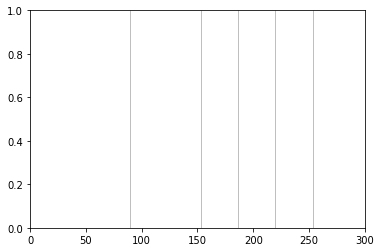

In [7]:
ax = jfm.plot()
ax.set_xlim(0, 300);

In [8]:
jfm._samples_within_bounds(2853122, 7093204 )

True

In [9]:
jfm._time_within_bounds(100, 250)

True

In [10]:
print("duration including gaps: {}".format(jfm.duration_w_gaps))
print("duration excluding gaps: {}".format(jfm.duration_wo_gaps))

duration including gaps: 2:43:336 minutes
duration excluding gaps: 1.7 milliseconds
